# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators = 100, max_depth = 5, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.learned_trees = []
        self.gamma = 1
        

        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        #for ...:
        #    y_new = ...
            # your code here
        self.remains = np.array(y)
        self.gammas = []
        
        for i in range(self.n_estimators):
            self.predictions = np.array(self._fit_predict_tree(x, self.remains))
            self.remains -= self.predictions
            
            

    def _fit_predict_tree(self, x, y):
        def gamma_func(gamma):
            return np.sum(((y - self.preds * gamma) ** 2)) / len(y)

        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.learned_trees.append(tree)
        
        self.preds = tree.predict(x)
        gamma = minimize(gamma_func, 0).x
        self.gammas.append(gamma)
        return gamma * self.learning_rate * self.preds
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = np.zeros(x.shape[0])
        for i in range(len(self.learned_trees)):
            y_pred += self.gammas[i] * self.learning_rate * self.learned_trees[i].predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

### Без подбора оптимального шага

In [28]:
np.random.seed(19052019)
gb = GradientBoosting(1000, 6)
gb.fit(X_train, y_train)
# your code here

In [29]:
mean_squared_error(y_test, gb.predict(X_test))

10.134744344837273

### С подбором оптимального шага

In [8]:
np.random.seed(19052019)
gb = GradientBoosting(200, 6, 0.2)
gb.fit(X_train, y_train)
# your code here

In [9]:
mean_squared_error(y_test, gb.predict(X_test))

9.598945919247429

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [113]:
import pandas as pd

In [191]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [115]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [116]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [113]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

/Users/igorgogarev/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7045694882576722

In [114]:
from sklearn.model_selection import GridSearchCV

In [115]:
params = {'n_estimators': np.arange(100, 1000, 200),
              'learning_rate': np.arange(0.1, 1, 0.3),
              'subsample': np.arange(0.2, 0.9, 0.3),
              'max_depth': np.arange(3, 8, 2),
              'min_child_weight': np.arange(1, 5, 2)
             }
xgb_gs = XGBClassifier()
clf = GridSearchCV(xgb_gs, params, scoring = 'roc_auc', n_jobs = -1)
clf.fit(X_train_part, y_train_part)

/Users/igorgogarev/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/igorgogarev/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [116]:
clf.best_score_

0.70314231722501

In [117]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.8}

### Попытка CatBoost

In [117]:
from catboost import CatBoostClassifier

In [192]:
y_train = train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

In [193]:
train.drop(['dep_delayed_15min'], axis = 1, inplace = True)

In [194]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423
...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140


In [195]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train, y_train, test_size=0.3)

In [222]:
model = CatBoostClassifier(iterations = 400,learning_rate = 0.4, eval_metric = 'AUC', custom_loss = 'AUC', cat_features = ['Month', 'DayofMonth', 'DayOfWeek','UniqueCarrier', 
                                          'Origin', 'Dest'])

In [223]:
model.fit(X_train_part, y_train_part)

0:	total: 22.2ms	remaining: 8.86s
1:	total: 47.3ms	remaining: 9.42s
2:	total: 68.1ms	remaining: 9.01s
3:	total: 95.3ms	remaining: 9.44s
4:	total: 117ms	remaining: 9.27s
5:	total: 143ms	remaining: 9.37s
6:	total: 169ms	remaining: 9.47s
7:	total: 196ms	remaining: 9.58s
8:	total: 218ms	remaining: 9.46s
9:	total: 249ms	remaining: 9.71s
10:	total: 272ms	remaining: 9.6s
11:	total: 298ms	remaining: 9.65s
12:	total: 322ms	remaining: 9.57s
13:	total: 346ms	remaining: 9.53s
14:	total: 368ms	remaining: 9.44s
15:	total: 396ms	remaining: 9.5s
16:	total: 420ms	remaining: 9.45s
17:	total: 445ms	remaining: 9.45s
18:	total: 470ms	remaining: 9.43s
19:	total: 498ms	remaining: 9.46s
20:	total: 524ms	remaining: 9.46s
21:	total: 548ms	remaining: 9.41s
22:	total: 571ms	remaining: 9.36s
23:	total: 595ms	remaining: 9.32s
24:	total: 621ms	remaining: 9.31s
25:	total: 644ms	remaining: 9.26s
26:	total: 665ms	remaining: 9.19s
27:	total: 691ms	remaining: 9.18s
28:	total: 715ms	remaining: 9.15s
29:	total: 740ms	remai

241:	total: 6.1s	remaining: 3.98s
242:	total: 6.13s	remaining: 3.96s
243:	total: 6.15s	remaining: 3.93s
244:	total: 6.18s	remaining: 3.91s
245:	total: 6.2s	remaining: 3.88s
246:	total: 6.23s	remaining: 3.86s
247:	total: 6.25s	remaining: 3.83s
248:	total: 6.28s	remaining: 3.81s
249:	total: 6.3s	remaining: 3.78s
250:	total: 6.33s	remaining: 3.76s
251:	total: 6.36s	remaining: 3.73s
252:	total: 6.38s	remaining: 3.71s
253:	total: 6.41s	remaining: 3.68s
254:	total: 6.43s	remaining: 3.66s
255:	total: 6.46s	remaining: 3.63s
256:	total: 6.48s	remaining: 3.61s
257:	total: 6.51s	remaining: 3.58s
258:	total: 6.53s	remaining: 3.56s
259:	total: 6.56s	remaining: 3.53s
260:	total: 6.58s	remaining: 3.51s
261:	total: 6.61s	remaining: 3.48s
262:	total: 6.63s	remaining: 3.46s
263:	total: 6.66s	remaining: 3.43s
264:	total: 6.69s	remaining: 3.41s
265:	total: 6.72s	remaining: 3.38s
266:	total: 6.74s	remaining: 3.36s
267:	total: 6.78s	remaining: 3.34s
268:	total: 6.81s	remaining: 3.31s
269:	total: 6.83s	remai

In [203]:
from sklearn.metrics import roc_auc_score

In [224]:
roc_auc_score(y_valid, model.predict(X_valid))

0.5888446187203602

In [225]:
roc_auc_score(y_train_part, model.predict(X_train_part))

0.6621482585221394

In [221]:
d = {'iterations': np.arange(100, 800, 300), 
     'learning_rate': np.arange(0.4, 0.8, 0.3)}
model.grid_search(d, X = train, y = y_train, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6671623	best: 0.6671623 (0)	total: 23.4ms	remaining: 2.32s
1:	test: 0.6693460	best: 0.6693460 (1)	total: 43.5ms	remaining: 2.13s
2:	test: 0.6895793	best: 0.6895793 (2)	total: 72.1ms	remaining: 2.33s
3:	test: 0.7008300	best: 0.7008300 (3)	total: 102ms	remaining: 2.44s
4:	test: 0.7040523	best: 0.7040523 (4)	total: 130ms	remaining: 2.47s
5:	test: 0.7051735	best: 0.7051735 (5)	total: 155ms	remaining: 2.42s
6:	test: 0.7081273	best: 0.7081273 (6)	total: 173ms	remaining: 2.3s
7:	test: 0.7112333	best: 0.7112333 (7)	total: 192ms	remaining: 2.21s
8:	test: 0.7116603	best: 0.7116603 (8)	total: 218ms	remaining: 2.21s
9:	test: 0.7135449	best: 0.7135449 (9)	total: 245ms	remaining: 2.2s
10:	test: 0.7146857	best: 0.7146857 (10)	total: 276ms	remaining: 2.23s
11:	test: 0.7152753	best: 0.7152753 (11)	total: 304ms	remaining: 2.23s
12:	test: 0.7164614	best: 0.7164614 (12)	total: 331ms	remaining: 2.21s
13:	test: 0.7169811	best: 0.7169811 (13)	total: 356ms	remaining: 2.19s
14:	test: 0.7178913	best:

16:	test: 0.7185734	best: 0.7185734 (16)	total: 453ms	remaining: 2.21s
17:	test: 0.7182804	best: 0.7185734 (16)	total: 482ms	remaining: 2.19s
18:	test: 0.7183575	best: 0.7185734 (16)	total: 506ms	remaining: 2.16s
19:	test: 0.7188711	best: 0.7188711 (19)	total: 533ms	remaining: 2.13s
20:	test: 0.7197220	best: 0.7197220 (20)	total: 558ms	remaining: 2.1s
21:	test: 0.7212450	best: 0.7212450 (21)	total: 583ms	remaining: 2.07s
22:	test: 0.7215648	best: 0.7215648 (22)	total: 611ms	remaining: 2.04s
23:	test: 0.7223290	best: 0.7223290 (23)	total: 638ms	remaining: 2.02s
24:	test: 0.7228006	best: 0.7228006 (24)	total: 664ms	remaining: 1.99s
25:	test: 0.7230403	best: 0.7230403 (25)	total: 691ms	remaining: 1.97s
26:	test: 0.7236553	best: 0.7236553 (26)	total: 711ms	remaining: 1.92s
27:	test: 0.7239414	best: 0.7239414 (27)	total: 734ms	remaining: 1.89s
28:	test: 0.7235363	best: 0.7239414 (27)	total: 760ms	remaining: 1.86s
29:	test: 0.7233828	best: 0.7239414 (27)	total: 785ms	remaining: 1.83s
30:	tes

27:	test: 0.7439971	best: 0.7441524 (26)	total: 1.05s	remaining: 14s
28:	test: 0.7443833	best: 0.7443833 (28)	total: 1.1s	remaining: 14.1s
29:	test: 0.7446392	best: 0.7446392 (29)	total: 1.14s	remaining: 14s
30:	test: 0.7448879	best: 0.7448879 (30)	total: 1.17s	remaining: 13.9s
31:	test: 0.7452271	best: 0.7452271 (31)	total: 1.21s	remaining: 13.9s
32:	test: 0.7453687	best: 0.7453687 (32)	total: 1.24s	remaining: 13.8s
33:	test: 0.7454794	best: 0.7454794 (33)	total: 1.28s	remaining: 13.8s
34:	test: 0.7459186	best: 0.7459186 (34)	total: 1.32s	remaining: 13.7s
35:	test: 0.7463570	best: 0.7463570 (35)	total: 1.36s	remaining: 13.7s
36:	test: 0.7464634	best: 0.7464634 (36)	total: 1.4s	remaining: 13.7s
37:	test: 0.7468224	best: 0.7468224 (37)	total: 1.43s	remaining: 13.7s
38:	test: 0.7470745	best: 0.7470745 (38)	total: 1.47s	remaining: 13.6s
39:	test: 0.7471753	best: 0.7471753 (39)	total: 1.51s	remaining: 13.6s
40:	test: 0.7475746	best: 0.7475746 (40)	total: 1.55s	remaining: 13.6s
41:	test: 0.

142:	test: 0.7581724	best: 0.7584995 (128)	total: 5.25s	remaining: 9.43s
143:	test: 0.7585115	best: 0.7585115 (143)	total: 5.29s	remaining: 9.39s
144:	test: 0.7585345	best: 0.7585345 (144)	total: 5.33s	remaining: 9.37s
145:	test: 0.7585493	best: 0.7585493 (145)	total: 5.37s	remaining: 9.34s
146:	test: 0.7589669	best: 0.7589669 (146)	total: 5.41s	remaining: 9.31s
147:	test: 0.7589510	best: 0.7589669 (146)	total: 5.44s	remaining: 9.27s
148:	test: 0.7587082	best: 0.7589669 (146)	total: 5.49s	remaining: 9.24s
149:	test: 0.7586501	best: 0.7589669 (146)	total: 5.52s	remaining: 9.21s
150:	test: 0.7585350	best: 0.7589669 (146)	total: 5.57s	remaining: 9.18s
151:	test: 0.7585120	best: 0.7589669 (146)	total: 5.61s	remaining: 9.15s
152:	test: 0.7584712	best: 0.7589669 (146)	total: 5.64s	remaining: 9.11s
153:	test: 0.7584815	best: 0.7589669 (146)	total: 5.68s	remaining: 9.07s
154:	test: 0.7585257	best: 0.7589669 (146)	total: 5.72s	remaining: 9.04s
155:	test: 0.7585150	best: 0.7589669 (146)	total: 5

256:	test: 0.7579606	best: 0.7591608 (160)	total: 9.67s	remaining: 5.38s
257:	test: 0.7579018	best: 0.7591608 (160)	total: 9.71s	remaining: 5.35s
258:	test: 0.7579341	best: 0.7591608 (160)	total: 9.75s	remaining: 5.31s
259:	test: 0.7580133	best: 0.7591608 (160)	total: 9.8s	remaining: 5.28s
260:	test: 0.7578196	best: 0.7591608 (160)	total: 9.83s	remaining: 5.24s
261:	test: 0.7578097	best: 0.7591608 (160)	total: 9.87s	remaining: 5.2s
262:	test: 0.7578260	best: 0.7591608 (160)	total: 9.9s	remaining: 5.16s
263:	test: 0.7578816	best: 0.7591608 (160)	total: 9.95s	remaining: 5.12s
264:	test: 0.7579425	best: 0.7591608 (160)	total: 9.98s	remaining: 5.08s
265:	test: 0.7577626	best: 0.7591608 (160)	total: 10s	remaining: 5.05s
266:	test: 0.7577181	best: 0.7591608 (160)	total: 10s	remaining: 5s
267:	test: 0.7578393	best: 0.7591608 (160)	total: 10.1s	remaining: 4.97s
268:	test: 0.7576990	best: 0.7591608 (160)	total: 10.1s	remaining: 4.93s
269:	test: 0.7577678	best: 0.7591608 (160)	total: 10.2s	remai

372:	test: 0.7574499	best: 0.7591809 (290)	total: 14.3s	remaining: 1.03s
373:	test: 0.7576348	best: 0.7591809 (290)	total: 14.3s	remaining: 994ms
374:	test: 0.7575641	best: 0.7591809 (290)	total: 14.3s	remaining: 956ms
375:	test: 0.7575133	best: 0.7591809 (290)	total: 14.4s	remaining: 918ms
376:	test: 0.7572791	best: 0.7591809 (290)	total: 14.4s	remaining: 879ms
377:	test: 0.7572565	best: 0.7591809 (290)	total: 14.4s	remaining: 841ms
378:	test: 0.7571527	best: 0.7591809 (290)	total: 14.5s	remaining: 803ms
379:	test: 0.7570767	best: 0.7591809 (290)	total: 14.5s	remaining: 765ms
380:	test: 0.7570587	best: 0.7591809 (290)	total: 14.6s	remaining: 727ms
381:	test: 0.7568588	best: 0.7591809 (290)	total: 14.6s	remaining: 689ms
382:	test: 0.7569022	best: 0.7591809 (290)	total: 14.6s	remaining: 650ms
383:	test: 0.7570076	best: 0.7591809 (290)	total: 14.7s	remaining: 612ms
384:	test: 0.7569788	best: 0.7591809 (290)	total: 14.7s	remaining: 574ms
385:	test: 0.7568751	best: 0.7591809 (290)	total: 1

83:	test: 0.7521240	best: 0.7525701 (74)	total: 3.2s	remaining: 12s
84:	test: 0.7519158	best: 0.7525701 (74)	total: 3.24s	remaining: 12s
85:	test: 0.7517875	best: 0.7525701 (74)	total: 3.28s	remaining: 12s
86:	test: 0.7515431	best: 0.7525701 (74)	total: 3.31s	remaining: 11.9s
87:	test: 0.7515547	best: 0.7525701 (74)	total: 3.34s	remaining: 11.8s
88:	test: 0.7518850	best: 0.7525701 (74)	total: 3.38s	remaining: 11.8s
89:	test: 0.7519896	best: 0.7525701 (74)	total: 3.41s	remaining: 11.8s
90:	test: 0.7519774	best: 0.7525701 (74)	total: 3.46s	remaining: 11.8s
91:	test: 0.7524043	best: 0.7525701 (74)	total: 3.5s	remaining: 11.7s
92:	test: 0.7526339	best: 0.7526339 (92)	total: 3.53s	remaining: 11.7s
93:	test: 0.7523386	best: 0.7526339 (92)	total: 3.57s	remaining: 11.6s
94:	test: 0.7521968	best: 0.7526339 (92)	total: 3.61s	remaining: 11.6s
95:	test: 0.7522285	best: 0.7526339 (92)	total: 3.65s	remaining: 11.5s
96:	test: 0.7522622	best: 0.7526339 (92)	total: 3.68s	remaining: 11.5s
97:	test: 0.75

198:	test: 0.7499246	best: 0.7535269 (116)	total: 7.38s	remaining: 7.45s
199:	test: 0.7498736	best: 0.7535269 (116)	total: 7.42s	remaining: 7.42s
200:	test: 0.7498360	best: 0.7535269 (116)	total: 7.46s	remaining: 7.38s
201:	test: 0.7496603	best: 0.7535269 (116)	total: 7.49s	remaining: 7.34s
202:	test: 0.7495156	best: 0.7535269 (116)	total: 7.54s	remaining: 7.31s
203:	test: 0.7495313	best: 0.7535269 (116)	total: 7.57s	remaining: 7.28s
204:	test: 0.7494550	best: 0.7535269 (116)	total: 7.61s	remaining: 7.24s
205:	test: 0.7493059	best: 0.7535269 (116)	total: 7.65s	remaining: 7.2s
206:	test: 0.7493846	best: 0.7535269 (116)	total: 7.68s	remaining: 7.16s
207:	test: 0.7493386	best: 0.7535269 (116)	total: 7.72s	remaining: 7.12s
208:	test: 0.7492414	best: 0.7535269 (116)	total: 7.75s	remaining: 7.08s
209:	test: 0.7491453	best: 0.7535269 (116)	total: 7.79s	remaining: 7.05s
210:	test: 0.7488163	best: 0.7535269 (116)	total: 7.83s	remaining: 7.01s
211:	test: 0.7485221	best: 0.7535269 (116)	total: 7.

313:	test: 0.7455380	best: 0.7535269 (116)	total: 11.5s	remaining: 3.16s
314:	test: 0.7454970	best: 0.7535269 (116)	total: 11.6s	remaining: 3.12s
315:	test: 0.7459150	best: 0.7535269 (116)	total: 11.6s	remaining: 3.09s
316:	test: 0.7458083	best: 0.7535269 (116)	total: 11.7s	remaining: 3.05s
317:	test: 0.7458938	best: 0.7535269 (116)	total: 11.7s	remaining: 3.01s
318:	test: 0.7458379	best: 0.7535269 (116)	total: 11.7s	remaining: 2.98s
319:	test: 0.7456825	best: 0.7535269 (116)	total: 11.8s	remaining: 2.94s
320:	test: 0.7454801	best: 0.7535269 (116)	total: 11.8s	remaining: 2.9s
321:	test: 0.7454445	best: 0.7535269 (116)	total: 11.8s	remaining: 2.87s
322:	test: 0.7453464	best: 0.7535269 (116)	total: 11.9s	remaining: 2.83s
323:	test: 0.7453763	best: 0.7535269 (116)	total: 11.9s	remaining: 2.79s
324:	test: 0.7446647	best: 0.7535269 (116)	total: 11.9s	remaining: 2.75s
325:	test: 0.7441725	best: 0.7535269 (116)	total: 12s	remaining: 2.72s
326:	test: 0.7441119	best: 0.7535269 (116)	total: 12s	

26:	test: 0.7441524	best: 0.7441524 (26)	total: 940ms	remaining: 23.4s
27:	test: 0.7439971	best: 0.7441524 (26)	total: 976ms	remaining: 23.4s
28:	test: 0.7443833	best: 0.7443833 (28)	total: 1.01s	remaining: 23.4s
29:	test: 0.7446392	best: 0.7446392 (29)	total: 1.05s	remaining: 23.4s
30:	test: 0.7448879	best: 0.7448879 (30)	total: 1.08s	remaining: 23.3s
31:	test: 0.7452271	best: 0.7452271 (31)	total: 1.11s	remaining: 23.2s
32:	test: 0.7453687	best: 0.7453687 (32)	total: 1.15s	remaining: 23.2s
33:	test: 0.7454794	best: 0.7454794 (33)	total: 1.19s	remaining: 23.3s
34:	test: 0.7459186	best: 0.7459186 (34)	total: 1.23s	remaining: 23.3s
35:	test: 0.7463570	best: 0.7463570 (35)	total: 1.26s	remaining: 23.3s
36:	test: 0.7464634	best: 0.7464634 (36)	total: 1.3s	remaining: 23.4s
37:	test: 0.7468224	best: 0.7468224 (37)	total: 1.34s	remaining: 23.4s
38:	test: 0.7470745	best: 0.7470745 (38)	total: 1.38s	remaining: 23.4s
39:	test: 0.7471753	best: 0.7471753 (39)	total: 1.41s	remaining: 23.3s
40:	tes

141:	test: 0.7581916	best: 0.7584995 (128)	total: 5.13s	remaining: 20.2s
142:	test: 0.7581724	best: 0.7584995 (128)	total: 5.17s	remaining: 20.1s
143:	test: 0.7585115	best: 0.7585115 (143)	total: 5.2s	remaining: 20.1s
144:	test: 0.7585345	best: 0.7585345 (144)	total: 5.24s	remaining: 20.1s
145:	test: 0.7585493	best: 0.7585493 (145)	total: 5.28s	remaining: 20s
146:	test: 0.7589669	best: 0.7589669 (146)	total: 5.32s	remaining: 20s
147:	test: 0.7589510	best: 0.7589669 (146)	total: 5.36s	remaining: 20s
148:	test: 0.7587082	best: 0.7589669 (146)	total: 5.4s	remaining: 20s
149:	test: 0.7586501	best: 0.7589669 (146)	total: 5.44s	remaining: 19.9s
150:	test: 0.7585350	best: 0.7589669 (146)	total: 5.49s	remaining: 20s
151:	test: 0.7585120	best: 0.7589669 (146)	total: 5.54s	remaining: 20s
152:	test: 0.7584712	best: 0.7589669 (146)	total: 5.58s	remaining: 20s
153:	test: 0.7584815	best: 0.7589669 (146)	total: 5.63s	remaining: 20s
154:	test: 0.7585257	best: 0.7589669 (146)	total: 5.68s	remaining: 20

254:	test: 0.7579488	best: 0.7591608 (160)	total: 9.86s	remaining: 17.2s
255:	test: 0.7579709	best: 0.7591608 (160)	total: 9.9s	remaining: 17.2s
256:	test: 0.7579606	best: 0.7591608 (160)	total: 9.94s	remaining: 17.1s
257:	test: 0.7579018	best: 0.7591608 (160)	total: 9.98s	remaining: 17.1s
258:	test: 0.7579341	best: 0.7591608 (160)	total: 10s	remaining: 17s
259:	test: 0.7580133	best: 0.7591608 (160)	total: 10.1s	remaining: 17s
260:	test: 0.7578196	best: 0.7591608 (160)	total: 10.1s	remaining: 17s
261:	test: 0.7578097	best: 0.7591608 (160)	total: 10.1s	remaining: 16.9s
262:	test: 0.7578260	best: 0.7591608 (160)	total: 10.2s	remaining: 16.9s
263:	test: 0.7578816	best: 0.7591608 (160)	total: 10.2s	remaining: 16.9s
264:	test: 0.7579425	best: 0.7591608 (160)	total: 10.3s	remaining: 16.9s
265:	test: 0.7577626	best: 0.7591608 (160)	total: 10.3s	remaining: 16.8s
266:	test: 0.7577181	best: 0.7591608 (160)	total: 10.3s	remaining: 16.8s
267:	test: 0.7578393	best: 0.7591608 (160)	total: 10.4s	rema

371:	test: 0.7574896	best: 0.7591809 (290)	total: 14.5s	remaining: 12.8s
372:	test: 0.7574499	best: 0.7591809 (290)	total: 14.5s	remaining: 12.7s
373:	test: 0.7576348	best: 0.7591809 (290)	total: 14.6s	remaining: 12.7s
374:	test: 0.7575641	best: 0.7591809 (290)	total: 14.6s	remaining: 12.7s
375:	test: 0.7575133	best: 0.7591809 (290)	total: 14.7s	remaining: 12.6s
376:	test: 0.7572791	best: 0.7591809 (290)	total: 14.7s	remaining: 12.6s
377:	test: 0.7572565	best: 0.7591809 (290)	total: 14.7s	remaining: 12.6s
378:	test: 0.7571527	best: 0.7591809 (290)	total: 14.8s	remaining: 12.5s
379:	test: 0.7570767	best: 0.7591809 (290)	total: 14.8s	remaining: 12.5s
380:	test: 0.7570587	best: 0.7591809 (290)	total: 14.9s	remaining: 12.4s
381:	test: 0.7568588	best: 0.7591809 (290)	total: 14.9s	remaining: 12.4s
382:	test: 0.7569022	best: 0.7591809 (290)	total: 14.9s	remaining: 12.4s
383:	test: 0.7570076	best: 0.7591809 (290)	total: 15s	remaining: 12.3s
384:	test: 0.7569788	best: 0.7591809 (290)	total: 15s

484:	test: 0.7572177	best: 0.7591809 (290)	total: 18.9s	remaining: 8.36s
485:	test: 0.7573601	best: 0.7591809 (290)	total: 18.9s	remaining: 8.32s
486:	test: 0.7573262	best: 0.7591809 (290)	total: 18.9s	remaining: 8.29s
487:	test: 0.7573583	best: 0.7591809 (290)	total: 19s	remaining: 8.25s
488:	test: 0.7574135	best: 0.7591809 (290)	total: 19s	remaining: 8.21s
489:	test: 0.7574440	best: 0.7591809 (290)	total: 19.1s	remaining: 8.17s
490:	test: 0.7573146	best: 0.7591809 (290)	total: 19.1s	remaining: 8.13s
491:	test: 0.7572544	best: 0.7591809 (290)	total: 19.1s	remaining: 8.09s
492:	test: 0.7571098	best: 0.7591809 (290)	total: 19.2s	remaining: 8.05s
493:	test: 0.7569419	best: 0.7591809 (290)	total: 19.2s	remaining: 8.01s
494:	test: 0.7570560	best: 0.7591809 (290)	total: 19.3s	remaining: 7.98s
495:	test: 0.7571349	best: 0.7591809 (290)	total: 19.3s	remaining: 7.94s
496:	test: 0.7571701	best: 0.7591809 (290)	total: 19.3s	remaining: 7.9s
497:	test: 0.7571021	best: 0.7591809 (290)	total: 19.4s	

602:	test: 0.7545983	best: 0.7591809 (290)	total: 23.5s	remaining: 3.78s
603:	test: 0.7544501	best: 0.7591809 (290)	total: 23.5s	remaining: 3.74s
604:	test: 0.7544471	best: 0.7591809 (290)	total: 23.6s	remaining: 3.7s
605:	test: 0.7544990	best: 0.7591809 (290)	total: 23.6s	remaining: 3.66s
606:	test: 0.7545386	best: 0.7591809 (290)	total: 23.7s	remaining: 3.63s
607:	test: 0.7546205	best: 0.7591809 (290)	total: 23.7s	remaining: 3.59s
608:	test: 0.7544240	best: 0.7591809 (290)	total: 23.7s	remaining: 3.55s
609:	test: 0.7542130	best: 0.7591809 (290)	total: 23.8s	remaining: 3.51s
610:	test: 0.7542103	best: 0.7591809 (290)	total: 23.8s	remaining: 3.47s
611:	test: 0.7542087	best: 0.7591809 (290)	total: 23.8s	remaining: 3.43s
612:	test: 0.7543383	best: 0.7591809 (290)	total: 23.9s	remaining: 3.39s
613:	test: 0.7542949	best: 0.7591809 (290)	total: 23.9s	remaining: 3.35s
614:	test: 0.7544487	best: 0.7591809 (290)	total: 24s	remaining: 3.31s
615:	test: 0.7543402	best: 0.7591809 (290)	total: 24s	

16:	test: 0.7411006	best: 0.7411006 (16)	total: 538ms	remaining: 21.6s
17:	test: 0.7414697	best: 0.7414697 (17)	total: 585ms	remaining: 22.2s
18:	test: 0.7430080	best: 0.7430080 (18)	total: 623ms	remaining: 22.3s
19:	test: 0.7436098	best: 0.7436098 (19)	total: 670ms	remaining: 22.8s
20:	test: 0.7437513	best: 0.7437513 (20)	total: 708ms	remaining: 22.9s
21:	test: 0.7448531	best: 0.7448531 (21)	total: 746ms	remaining: 23s
22:	test: 0.7460336	best: 0.7460336 (22)	total: 776ms	remaining: 22.9s
23:	test: 0.7469383	best: 0.7469383 (23)	total: 814ms	remaining: 22.9s
24:	test: 0.7471989	best: 0.7471989 (24)	total: 852ms	remaining: 23s
25:	test: 0.7476596	best: 0.7476596 (25)	total: 888ms	remaining: 23s
26:	test: 0.7480118	best: 0.7480118 (26)	total: 929ms	remaining: 23.2s
27:	test: 0.7478559	best: 0.7480118 (26)	total: 969ms	remaining: 23.2s
28:	test: 0.7480078	best: 0.7480118 (26)	total: 1s	remaining: 23.2s
29:	test: 0.7483694	best: 0.7483694 (29)	total: 1.04s	remaining: 23.2s
30:	test: 0.749

136:	test: 0.7509653	best: 0.7535269 (116)	total: 4.96s	remaining: 20.4s
137:	test: 0.7510733	best: 0.7535269 (116)	total: 4.99s	remaining: 20.3s
138:	test: 0.7512459	best: 0.7535269 (116)	total: 5.03s	remaining: 20.3s
139:	test: 0.7510400	best: 0.7535269 (116)	total: 5.07s	remaining: 20.3s
140:	test: 0.7511073	best: 0.7535269 (116)	total: 5.11s	remaining: 20.2s
141:	test: 0.7510572	best: 0.7535269 (116)	total: 5.15s	remaining: 20.2s
142:	test: 0.7510786	best: 0.7535269 (116)	total: 5.19s	remaining: 20.2s
143:	test: 0.7508545	best: 0.7535269 (116)	total: 5.23s	remaining: 20.2s
144:	test: 0.7510840	best: 0.7535269 (116)	total: 5.26s	remaining: 20.1s
145:	test: 0.7510582	best: 0.7535269 (116)	total: 5.3s	remaining: 20.1s
146:	test: 0.7511977	best: 0.7535269 (116)	total: 5.34s	remaining: 20.1s
147:	test: 0.7513478	best: 0.7535269 (116)	total: 5.38s	remaining: 20.1s
148:	test: 0.7515652	best: 0.7535269 (116)	total: 5.42s	remaining: 20s
149:	test: 0.7516937	best: 0.7535269 (116)	total: 5.46

252:	test: 0.7456342	best: 0.7535269 (116)	total: 9.44s	remaining: 16.7s
253:	test: 0.7454488	best: 0.7535269 (116)	total: 9.48s	remaining: 16.6s
254:	test: 0.7455551	best: 0.7535269 (116)	total: 9.51s	remaining: 16.6s
255:	test: 0.7453872	best: 0.7535269 (116)	total: 9.55s	remaining: 16.6s
256:	test: 0.7455343	best: 0.7535269 (116)	total: 9.58s	remaining: 16.5s
257:	test: 0.7452662	best: 0.7535269 (116)	total: 9.62s	remaining: 16.5s
258:	test: 0.7451994	best: 0.7535269 (116)	total: 9.65s	remaining: 16.4s
259:	test: 0.7451588	best: 0.7535269 (116)	total: 9.69s	remaining: 16.4s
260:	test: 0.7452001	best: 0.7535269 (116)	total: 9.73s	remaining: 16.4s
261:	test: 0.7452510	best: 0.7535269 (116)	total: 9.77s	remaining: 16.3s
262:	test: 0.7454316	best: 0.7535269 (116)	total: 9.8s	remaining: 16.3s
263:	test: 0.7453017	best: 0.7535269 (116)	total: 9.84s	remaining: 16.3s
264:	test: 0.7452961	best: 0.7535269 (116)	total: 9.88s	remaining: 16.2s
265:	test: 0.7452715	best: 0.7535269 (116)	total: 9.

367:	test: 0.7412918	best: 0.7535269 (116)	total: 14s	remaining: 12.6s
368:	test: 0.7410558	best: 0.7535269 (116)	total: 14s	remaining: 12.6s
369:	test: 0.7412154	best: 0.7535269 (116)	total: 14.1s	remaining: 12.6s
370:	test: 0.7410829	best: 0.7535269 (116)	total: 14.1s	remaining: 12.5s
371:	test: 0.7408219	best: 0.7535269 (116)	total: 14.2s	remaining: 12.5s
372:	test: 0.7407959	best: 0.7535269 (116)	total: 14.2s	remaining: 12.4s
373:	test: 0.7408769	best: 0.7535269 (116)	total: 14.2s	remaining: 12.4s
374:	test: 0.7408268	best: 0.7535269 (116)	total: 14.3s	remaining: 12.4s
375:	test: 0.7409098	best: 0.7535269 (116)	total: 14.3s	remaining: 12.3s
376:	test: 0.7409705	best: 0.7535269 (116)	total: 14.4s	remaining: 12.3s
377:	test: 0.7409088	best: 0.7535269 (116)	total: 14.4s	remaining: 12.3s
378:	test: 0.7409302	best: 0.7535269 (116)	total: 14.4s	remaining: 12.2s
379:	test: 0.7409219	best: 0.7535269 (116)	total: 14.5s	remaining: 12.2s
380:	test: 0.7410390	best: 0.7535269 (116)	total: 14.5s

484:	test: 0.7381206	best: 0.7535269 (116)	total: 18.6s	remaining: 8.24s
485:	test: 0.7380379	best: 0.7535269 (116)	total: 18.6s	remaining: 8.2s
486:	test: 0.7378566	best: 0.7535269 (116)	total: 18.7s	remaining: 8.17s
487:	test: 0.7377297	best: 0.7535269 (116)	total: 18.7s	remaining: 8.13s
488:	test: 0.7380699	best: 0.7535269 (116)	total: 18.7s	remaining: 8.09s
489:	test: 0.7380127	best: 0.7535269 (116)	total: 18.8s	remaining: 8.04s
490:	test: 0.7379919	best: 0.7535269 (116)	total: 18.8s	remaining: 8.01s
491:	test: 0.7381491	best: 0.7535269 (116)	total: 18.9s	remaining: 7.97s
492:	test: 0.7381886	best: 0.7535269 (116)	total: 18.9s	remaining: 7.93s
493:	test: 0.7379747	best: 0.7535269 (116)	total: 18.9s	remaining: 7.89s
494:	test: 0.7379079	best: 0.7535269 (116)	total: 19s	remaining: 7.85s
495:	test: 0.7379621	best: 0.7535269 (116)	total: 19s	remaining: 7.81s
496:	test: 0.7376813	best: 0.7535269 (116)	total: 19s	remaining: 7.78s
497:	test: 0.7376003	best: 0.7535269 (116)	total: 19.1s	re

600:	test: 0.7316981	best: 0.7535269 (116)	total: 23.3s	remaining: 3.83s
601:	test: 0.7317246	best: 0.7535269 (116)	total: 23.3s	remaining: 3.79s
602:	test: 0.7315940	best: 0.7535269 (116)	total: 23.3s	remaining: 3.75s
603:	test: 0.7316010	best: 0.7535269 (116)	total: 23.4s	remaining: 3.72s
604:	test: 0.7317368	best: 0.7535269 (116)	total: 23.4s	remaining: 3.68s
605:	test: 0.7319331	best: 0.7535269 (116)	total: 23.5s	remaining: 3.64s
606:	test: 0.7318971	best: 0.7535269 (116)	total: 23.5s	remaining: 3.6s
607:	test: 0.7318337	best: 0.7535269 (116)	total: 23.5s	remaining: 3.56s
608:	test: 0.7319222	best: 0.7535269 (116)	total: 23.6s	remaining: 3.52s
609:	test: 0.7318291	best: 0.7535269 (116)	total: 23.6s	remaining: 3.48s
610:	test: 0.7317551	best: 0.7535269 (116)	total: 23.7s	remaining: 3.45s
611:	test: 0.7317887	best: 0.7535269 (116)	total: 23.7s	remaining: 3.41s
612:	test: 0.7317501	best: 0.7535269 (116)	total: 23.8s	remaining: 3.37s
613:	test: 0.7316798	best: 0.7535269 (116)	total: 23

14:	test: 0.7371868	best: 0.7371868 (14)
15:	test: 0.7376443	best: 0.7376443 (15)
16:	test: 0.7381884	best: 0.7381884 (16)
17:	test: 0.7386781	best: 0.7386781 (17)
18:	test: 0.7395071	best: 0.7395071 (18)
19:	test: 0.7397037	best: 0.7397037 (19)
20:	test: 0.7409436	best: 0.7409436 (20)
21:	test: 0.7413585	best: 0.7413585 (21)
22:	test: 0.7416125	best: 0.7416125 (22)
23:	test: 0.7418487	best: 0.7418487 (23)
24:	test: 0.7419454	best: 0.7419454 (24)
25:	test: 0.7428139	best: 0.7428139 (25)
26:	test: 0.7431904	best: 0.7431904 (26)	total: 3s	remaining: 41.5s
27:	test: 0.7438118	best: 0.7438118 (27)
28:	test: 0.7440859	best: 0.7440859 (28)
29:	test: 0.7442626	best: 0.7442626 (29)
30:	test: 0.7445332	best: 0.7445332 (30)
31:	test: 0.7450926	best: 0.7450926 (31)
32:	test: 0.7454700	best: 0.7454700 (32)
33:	test: 0.7458821	best: 0.7458821 (33)
34:	test: 0.7463391	best: 0.7463391 (34)
35:	test: 0.7464268	best: 0.7464268 (35)
36:	test: 0.7467286	best: 0.7467286 (36)
37:	test: 0.7470170	best: 0.74

206:	test: 0.7551592	best: 0.7555171 (163)
207:	test: 0.7551262	best: 0.7555171 (163)
208:	test: 0.7551376	best: 0.7555171 (163)
209:	test: 0.7551591	best: 0.7555171 (163)
210:	test: 0.7552161	best: 0.7555171 (163)
211:	test: 0.7550737	best: 0.7555171 (163)
212:	test: 0.7550802	best: 0.7555171 (163)
213:	test: 0.7551087	best: 0.7555171 (163)
214:	test: 0.7550031	best: 0.7555171 (163)	total: 23.1s	remaining: 19.8s
215:	test: 0.7549789	best: 0.7555171 (163)
216:	test: 0.7549034	best: 0.7555171 (163)
217:	test: 0.7548929	best: 0.7555171 (163)
218:	test: 0.7548738	best: 0.7555171 (163)
219:	test: 0.7548812	best: 0.7555171 (163)
220:	test: 0.7548664	best: 0.7555171 (163)
221:	test: 0.7547550	best: 0.7555171 (163)
222:	test: 0.7547089	best: 0.7555171 (163)
223:	test: 0.7547261	best: 0.7555171 (163)
224:	test: 0.7547439	best: 0.7555171 (163)
225:	test: 0.7547188	best: 0.7555171 (163)
226:	test: 0.7546502	best: 0.7555171 (163)
227:	test: 0.7545847	best: 0.7555171 (163)	total: 24.5s	remaining: 

391:	test: 0.7531497	best: 0.7555171 (163)
392:	test: 0.7531156	best: 0.7555171 (163)
393:	test: 0.7530792	best: 0.7555171 (163)
394:	test: 0.7530321	best: 0.7555171 (163)
395:	test: 0.7530094	best: 0.7555171 (163)
396:	test: 0.7529668	best: 0.7555171 (163)
397:	test: 0.7529588	best: 0.7555171 (163)
398:	test: 0.7530275	best: 0.7555171 (163)
399:	test: 0.7531022	best: 0.7555171 (163)	total: 42.7s	remaining: 0us


{'params': {'iterations': 400, 'learning_rate': 0.4},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               4

По графику можно видеть, что при iterations = 400 и learning_rate = 0.4 качество на тесте должно быть больше, чем 0.75

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [272]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [270]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.label = 0 # 0 if non-casterized, >= 1 if clasterized, -1 if noise

In [268]:
# Рекомендации -- это только рекомендации
class DBscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.points = np.empty(len(X[0]), dtype = type(Point))
        for i in range(len(X[0])):
            self.points[i] = Point(X[0][i], X[1][i])
       
        for i in range(len(self.points)):
            if(self.points[i].label != 0):
                continue
            close_points = self.range_query(self.points[i])
            if len(close_points) < self.min_samples:
                self.points[i].label = -1
                continue
            self.n_clusters += 1
            self.points[i].label = self.n_clusters
            k = 0
            while(k < len(close_points)):
               # if(DBscan.dist(close_points[k], self.points[i]) == 0):
               #     k += 1
               #     continue
                if close_points[k].label == -1:
                    close_points[k].label = self.n_clusters
                if close_points[k].label != 0:
                    k += 1
                    continue
                close_points[k].label = self.n_clusters
                neighs = self.range_query(close_points[k])
                if(len(neighs) > self.min_samples):
                    close_points = close_points + neighs
                k += 1
                    
        clusters = np.empty(len(self.points))
        for i in range(len(clusters)):
            clusters[i] = self.points[i].label
        return clusters
                
                    
            
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        pass
        

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        close_points = []
        for i in range(len(self.points)):
            if DBscan.dist(x, self.points[i]) <= self.eps:
                close_points.append(self.points[i])
        return close_points
        
        
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.cdist(XA = [(a.x, a.y)],XB = [(b.x, b.y)])

In [264]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

Проверим себя на простом примере:

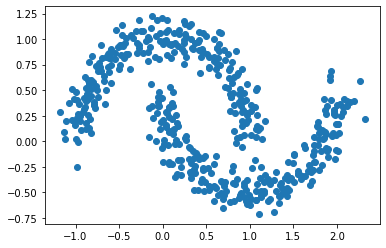

In [299]:


X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [300]:
db = DBscan(eps=0.195, min_samples = 10)
clusters = np.array(db.fit_predict(np.vstack([X[:,0], X[:,1]])))


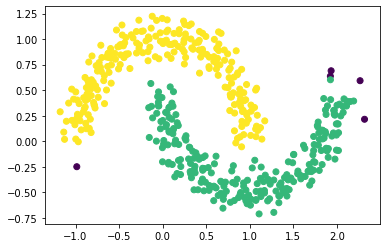

In [301]:
plt.scatter(X[:,0], X[:,1], c=clusters)

Референс:

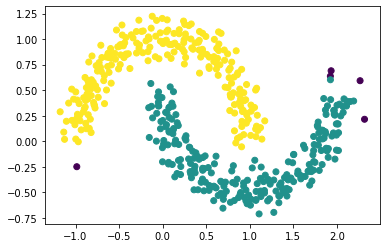

In [302]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [303]:
from sklearn.datasets import make_circles, make_moons
X, _ = make_circles(n_samples=500, noise = 0.01)
X2, _ = make_moons(n_samples=500)

X_set = np.concatenate([X[:,0],(X2[:,0] * 2 - 3)])
Y_set = np.concatenate([X[:,1],(X2[:,1] +2)])

db_2 = DBscan(eps=0.15, min_samples = 10)
clusters_2 = np.array(db_2.fit_predict(np.vstack([X_set, Y_set])))



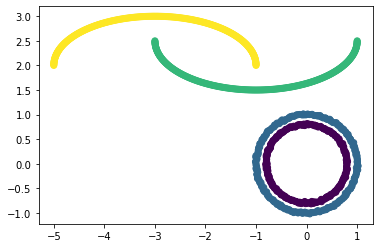

In [304]:
plt.scatter(X_set, Y_set, c=clusters_2)

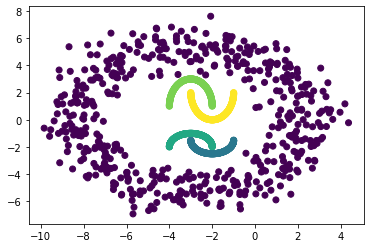

In [237]:
X, _ = make_circles(n_samples=500, noise = 0.1)
X2, _ = make_moons(n_samples=500)
X3, _ = make_moons(n_samples = 500)

X_set = np.concatenate([X[:,0] * 6 - 3,(X2[:,0] - 3), X3[:, 0] - 3])
Y_set = np.concatenate([X[:,1] * 6,(X2[:,1] -2), 2*(X3[:, 1] + 0.5)])

db_2 = DBscan(eps=0.23, min_samples = 10)
clusters_2 = np.array(db_2.fit_predict(np.vstack([X_set, Y_set])))

plt.scatter(X_set, Y_set, c=clusters_2)

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

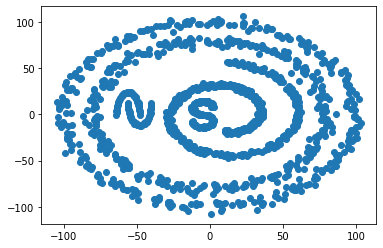

In [ ]:
# your code here

Или хотя бы что-нибудь такое: 

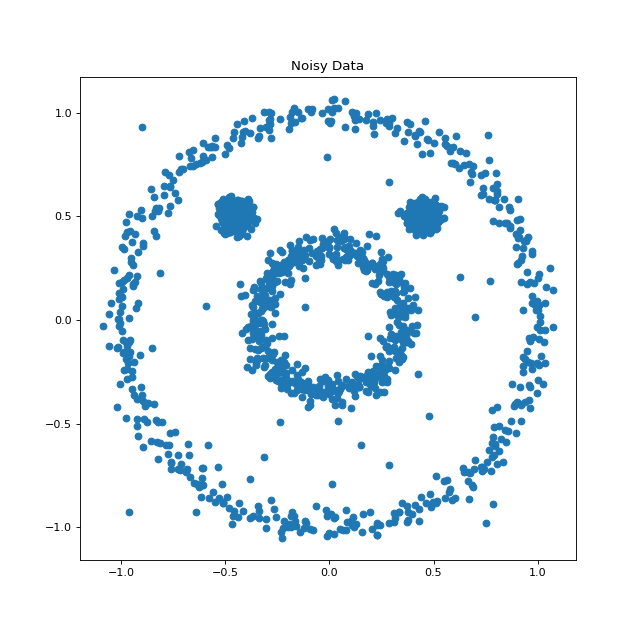

In [ ]:
# your code here

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [325]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 12.7 ms, sys: 1.77 ms, total: 14.5 ms
Wall time: 12.4 ms


In [324]:
%%time
%%capture
clusters = DBscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 3.49 ms, sys: 135 µs, total: 3.62 ms
Wall time: 3.53 ms
